C:\Users\pawma\AppData\Local\Temp\ipykernel_35536\910847104.py:56: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  binary_closed = closing(binary, square(3))


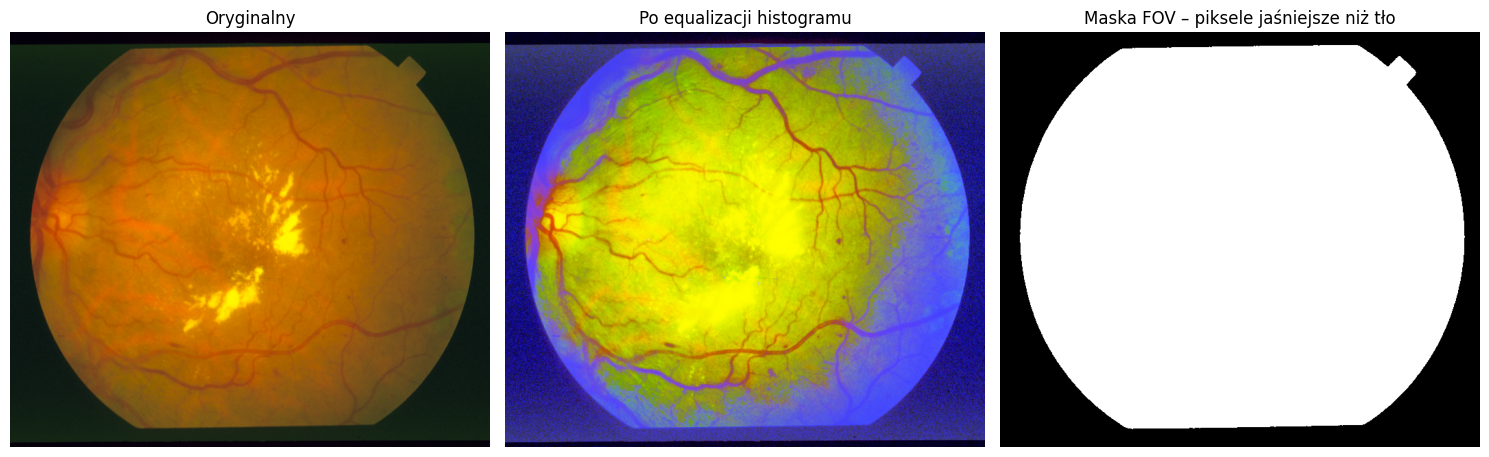

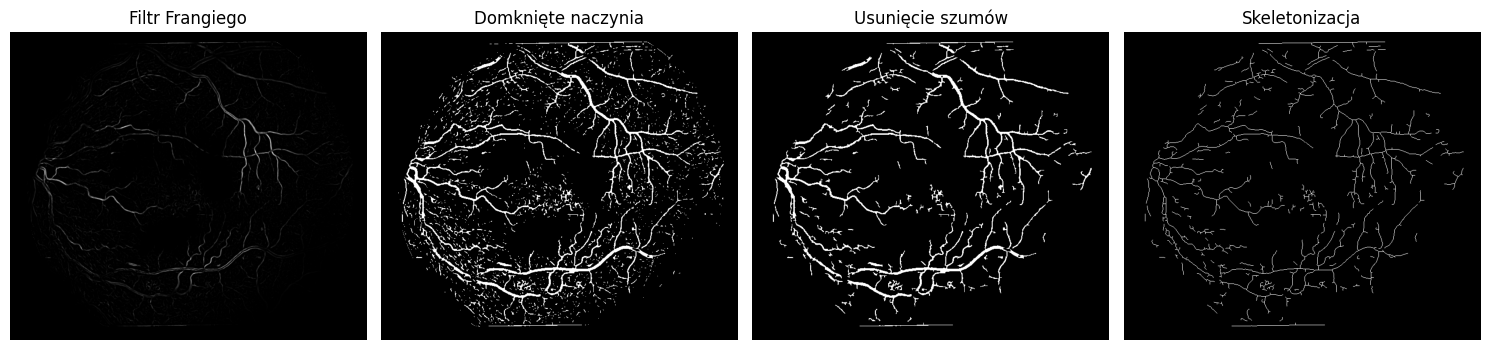

Accuracy: 0.9399
Sensitivity: 0.4715
Specificity: 0.9806
Balanced Accuracy: 0.7260


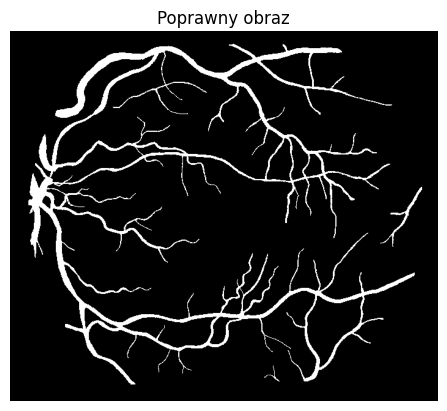

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import frangi
from skimage.color import rgb2gray
from skimage.morphology import closing, square
from skimage.morphology import remove_small_objects
from skimage.morphology import skeletonize

# 1. Wczytaj kolorowy obraz (BGR)
img = cv2.imread("images/im0001.ppm")

gray_mask = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Tworzenie maski
_, fov_mask = cv2.threshold(gray_mask, 45, 255, cv2.THRESH_BINARY)
fov_mask = fov_mask > 0  # zamień na maskę logiczną


# 1 sposób -----------------------------------------------------------------------------------------------------
# 2. Rozdziel kanały BGR
b, g, r = cv2.split(img)

# 3. Equalizacja histogramu na każdym kanale osobno
b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

# 4. Połącz ponownie do obrazu BGR
img_eq = cv2.merge((b_eq, g_eq, r_eq))
# ---------------------------------------------------------------------------------------------------------------

# 2 sposób ------------------------------------------------------------------------------------------------------
# # Equalizacja tylko jasności Y (w przestrzeni YCrCb) – kolory zostają naturalne
# img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
# img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # equalizacja jasności Y
# img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YCrCb2BGR)
# ---------------------------------------------------------------------------------------------------------------


# 5. Konwersja BGR → RGB (skimage używa RGB)
img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_BGR2RGB)

# 6. Konwersja RGB → Grayscale (float, 0–1)
gray = rgb2gray(img_rgb)

# 7. Zastosowanie filtra Frangiego
frangi_result = frangi(gray)

frangi_result[~fov_mask] = 0

# 8. Progowanie (zamiana obrazu na true -> białe, false -> czarne pixele)
binary = frangi_result > 0.03 

#9. Domyka naczynia
binary_closed = closing(binary, square(3))

#10. Usunięcie szumów
binary_cleaned = remove_small_objects(binary_closed, min_size=20)

#11. Zamienia naczyniana cienkie linie 1px grubości
binary_skeleton = skeletonize(binary_cleaned)

# Wyświetlenie wyników
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Oryginalny")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Po equalizacji histogramu")
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Maska FOV – piksele jaśniejsze niż tło")
plt.imshow(fov_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("Filtr Frangiego")
plt.imshow(frangi_result, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Domknięte naczynia")
plt.imshow(binary_closed, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Usunięcie szumów")
plt.imshow(binary_cleaned, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Skeletonizacja")
plt.imshow(binary_skeleton, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# Wczytywanie gotowych poprawnych obrazów dna siatkówki oka + progowanie
ideal_result = cv2.imread("images/im0001.ah.ppm", 0) > 0
# ideal_result = cv2.imread("results/im0001-vessels4.ppm", 0) > 0


plt.subplot(1, 1, 1)
plt.title("Poprawny obraz")
plt.imshow(ideal_result, cmap='gray')
plt.axis('off')


TP = np.logical_and(binary_cleaned == 1, ideal_result == 1).sum()
TN = np.logical_and(binary_cleaned == 0, ideal_result == 0).sum()
FP = np.logical_and(binary_cleaned == 1, ideal_result == 0).sum()
FN = np.logical_and(binary_cleaned == 0, ideal_result == 1).sum()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
balanced_accuracy = (sensitivity + specificity) / 2

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")


